# Importações

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

# Adquirindo os metadados

In [52]:
df = pd.read_csv(os.path.join("datasets","HAM10000","dataverse_files","HAM10000_metadata"))

In [53]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


# Visualização das Categorias

<BarContainer object of 7 artists>

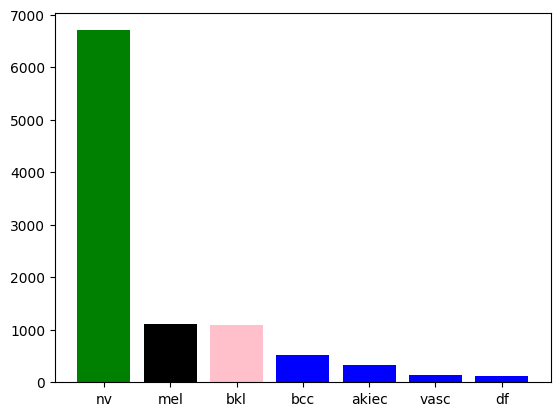

In [55]:
counts = df['dx'].value_counts() 

plt.bar(counts.index, counts,color=['green','black','pink','blue','blue','blue','blue'])

In [56]:
counts

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [7]:
counts['nv']/counts.sum()

0.6694957563654518

# Boxplot

<Axes: ylabel='age'>

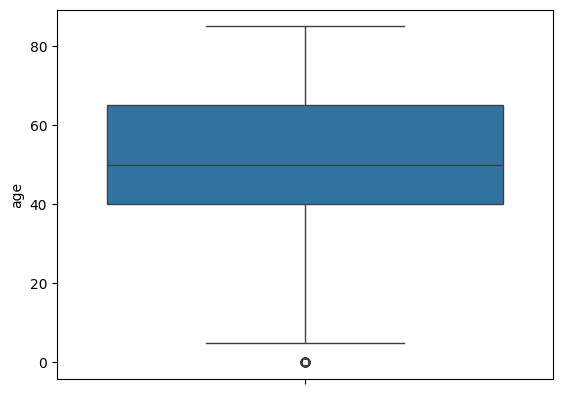

In [8]:
sns.boxplot(df['age'])

In [9]:
df['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

In [10]:
df[df['sex']=='male']['sex'].count()/df.shape[0]

0.5397903145282077

# Diminuindo a Quantidade
esse procedimento visa diminuir o desbalanceamento e também tornar mais rápido o treinamento

In [57]:
linhas_excluir_nv = df[df['dx']=="nv"].sample(frac=0.97,random_state=42)
linhas_excluir_mel = df[df['dx']=="mel"].sample(frac=0.82,random_state=42)
linhas_excluir_bkl = df[df['dx']=="bkl"].sample(frac=0.81,random_state=42)
linhas_excluir_bcc = df[df['dx']=="bcc"].sample(frac=0.61,random_state=42)
df = df.drop(linhas_excluir_nv.index)
df = df.drop(linhas_excluir_mel.index)
df = df.drop(linhas_excluir_bkl.index)
df = df.drop(linhas_excluir_bcc.index)

# Mudanças de Categorias

In [20]:
# mopm : maligna ou potencialmente maligna
df['dx'] = df['dx'].apply(lambda categoria: "mopm" if categoria in ["bcc","akiec"] else "benigna" if categoria in ["nv","vasc","df"] else categoria)

In [21]:
df['dx'].value_counts()

dx
benigna    1598
mel        1113
bkl        1099
mopm        841
Name: count, dtype: int64

# Excluir categorias

In [58]:
df.drop(df[df['dx'].isin(['akiec','vasc','df'])].index,inplace=True)

In [59]:
df.shape

(810, 8)

In [60]:
df['dx'].value_counts()

dx
bkl    209
nv     201
mel    200
bcc    200
Name: count, dtype: int64

In [62]:
X_train,X_test,y_train,y_test = train_test_split(df.drop("dx",axis=1),df['dx'],test_size=0.2,random_state=42,stratify=df['dx'])

In [63]:
def organizar_pastas(destino):
    origens = [
        os.path.join("datasets","HAM10000","dataverse_files","HAM10000_images_part_1"),
        os.path.join("datasets","HAM10000","dataverse_files","HAM10000_images_part_2")
    ]
    os.makedirs(destino,exist_ok=True)

    
    for categoria in df['dx'].value_counts().index:       
        os.makedirs(os.path.join(destino,"treino",categoria),exist_ok=True)
        os.makedirs(os.path.join(destino,"validacao",categoria),exist_ok=True)
        
    for image_id,categoria in zip(X_train["image_id"],y_train):
        try:
            shutil.copy2(os.path.join(origens[0],image_id+".jpg"),os.path.join(destino,"treino",categoria))
        except:
            shutil.copy2(os.path.join(origens[1],image_id+".jpg"),os.path.join(destino,"treino",categoria))

    for image_id,categoria in zip(X_test["image_id"],y_test):
        try:
            shutil.copy2(os.path.join(origens[0],image_id+".jpg"),os.path.join(destino,"validacao",categoria))
        except:
            shutil.copy2(os.path.join(origens[1],image_id+".jpg"),os.path.join(destino,"validacao",categoria))

In [64]:
organizar_pastas(os.path.join("datasets","HAM10000_ESTRUTURADO"))

# SALVAR DATAFRAME

In [66]:
y_test.to_csv("y_test_v3.csv",index=False)